# Module 7 - Large Languague Models

_PAS4AI Workforce Summer 2024_

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joonbugs/PAS4AI-Summer-24/blob/main/7-Large_Language_Models.ipynb)

In [ ]:
'''
###############################################
# YOU MAY IGNORE ALL OF THE CODE IN THIS CELL # (but you should run it)
###############################################
'''
import requests
import json

COLAB = True
if COLAB:
    from google.colab import userdata
    PROXY_KEY = userdata.get("proxy_key")
else:
    import configparser
    key_config = configparser.ConfigParser()
    key_config.read('keys.cfg') # keys.cfg should NOT have any quote symbols in the text
    PROXY_KEY = key_config["DEFAULT"]["PROXY"]

def builder_llama3_instruct(system, dialogue):
    # https://github.com/meta-llama/llama3/blob/main/llama/tokenizer.py#L202
    prompt = "<|begin_of_text|>"
    if system is not None:
        prompt += f"<|start_header_id|>system<|end_header_id|>\n\n{system}<|eot_id|>"
    for d in dialogue:
        prompt += f"<|start_header_id|>{d['role']}<|end_header_id|>\n\n{d['content']}<|eot_id|>"
    prompt += "<|start_header_id|>assistant<|end_header_id|>\n\n"
    return prompt


def llama3_response(system, dialogue, log_params, model=70):
    prompt = builder_llama3_instruct(system, dialogue)
    # print(prompt)
    api_url = f"https://pas4ai.rorytm.com/proxy/bedrock/meta.llama3-{model}b-instruct-v1:0"
    body = {
        "prompt": prompt,
        "max_gen_len": 2048,
        "temperature": 0.5,
        "top_p": 0.9,
        "log_params": log_params,
    }
    headers = {"Authorization": f"Bearer {PROXY_KEY}"}
    response =  requests.post(api_url, headers=headers, json=body)
    # print(response)
    response_json = response.json().get("generation")
    return response_json

claude_sys = "You are Claude, an AI assistant created by Anthropic to be helpful, harmless, and honest. \
            Your goal is to provide informative and substantive responses to queries while avoiding potential harms."

def claude3_response(system, dialogue, log_params, model="claude-3-sonnet-20240229-v1:0"):
    api_url = f"https://pas4ai.rorytm.com:8001/proxy/bedrock/anthropic.{model}"
    body = {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 2048,
        "temperature": 1,
        "system": system,
        "messages": dialogue,
        "log_params": log_params,
    }
    headers = {"Authorization": f"Bearer {PROXY_KEY}"}
    response = requests.post(api_url, headers=headers, json=body)
    response_body = response.content.decode("utf-8")
    response_json = json.loads(response_body).get("content")
    return response_json

LLAMA2_CHAT_HF_SYS_PROMPT = \
"""You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."""

def builder_llama2_chat(prompt, system_prompt=LLAMA2_CHAT_HF_SYS_PROMPT):
    full_prompt = \
    f"""<s>[INST] <<SYS>>
    {system_prompt}
    <</SYS>>

    {prompt} [/INST]"""
    return full_prompt

def llama2_chat_response(prompt, log_params={"source": "llm_notebook"}, model=70):
    prompt = builder_llama2_chat(prompt)

    # print(prompt)
    api_url = f"https://pas4ai.rorytm.com/proxy/bedrock/meta.llama2-{model}b-chat-v1"
    body = {
        "prompt": prompt,
        "max_gen_len": 2048,
        "temperature": 0.5,
        "top_p": 0.9,
        "log_params": log_params,
    }
    headers = {"Authorization": f"Bearer {PROXY_KEY}"}
    response =  requests.post(api_url, headers=headers, json=body)
    # print(response)
    generation = response.json().get("generation")
    return generation.strip()

def llama3_simple_response(prompt, model=70):
    completion = llama3_response(None, [{'role': 'user', 'content': prompt}], log_params={"source": "llm_notebook"}, model=model)
    return completion

def claude_simple_response(prompt):
    messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                ],
            }
        ]
    return claude3_response(claude_sys, messages, {"source": "llm_notebook"})[0]['text']

#### LLM Usage: You may use the "modules-llm" to answer questions AFTER you have attempted an answer without. Put your partial answer attempted (without LLM use) in addition to your final answer in the "Answer" cell. You should put all prompts that you used and their responses in cells either immediately before or after an "Answer" cell. If you use it to find out what a function does, you should also search for that answer online and see if you can find it/understand the documentation - state this as a comment in your answer cell.


# Large Language Models (LLMs)

## What are LLMs?

LLMs are artificial neural networks which are trained on a large amount of text data. They are trained to predict the next tokens (words) when passed in some input tokens. For example when passed in the tokens "She is a computer" the model may predict "scientist" as the next token, because it has been trained with the similar (or the same) sentence previously.

LLMs can also be utilized to solve other tasks like question answering. For example, if an LLM was passed in the input "Answer the question. Q: What is the capital of the United States? A:" it would try to complete the text with the most likely token which is probably the answer to the question.

Some examples of popular LLMs are ChatGPT, LLaMA and Gemini.

In [ ]:
# Here is an example of utilizing an LLM to complete the text, to answer a question
llama3_simple_response("Answer the question. Q: What is the capital of the United States? A:")

Here are some use cases of LLMs from Forbes (https://www.forbes.com/sites/forbestechcouncil/2024/03/07/successful-real-world-use-cases-for-llms-and-lessons-they-teach/)

1. Assisting With Clinical Diagnoses
2. Mapping Cybersecurity Regulations To Policies And Controls
3. Expediting Claims Processing
4. Tracking And Analyzing Customer Feedback
5. Fielding Customer Service Questions
6. Enhancing Developer Productivity
7. Detecting Signs Of Malware
8. Providing Customers With Immediate Assistance
9. Troubleshooting Equipment Issues
10. Summarizing Application Details
11. Automating Customer Relationship Tasks
12. Answering Both Simple And Complex Questions
13. Scraping Online Data
14. Powering Market Research
15. Simplifying Analytics Review
16. Creating Semantic Maps Of Complex Topics
17. Curating Scientific Literature
18. Powering Internal Knowledge Bases
19. Brainstorming Marketing Content
20. Generating Test Data

### Question 1

For your assigned application area:

1. Give a 1-3 sentence description explaining the application area.
2. Who does this application help? (Who is the target audience/User)
3. How would you achieve this without LLMs?
4. Write an example prompt which could be used for this application area.
5. Do you think this application area is good for society and why?


### Answer 1

\<*Type your answer here*\>


## Prompting
A **prompt** is a input text which is used to look for an appropriate output or **completion**. As previously mentioned, "Answer the question. Q: What is the capital of the United States? A:" is a prompt which is looking for an answer to the question. When the model was trained it has most likely seen a lot of questions and answers in the form of "Q: \<QUESTION\> A: \<ANSWER\>" so the model learns to try to answer the question, when presented with text in that format.

Here are some prompting tips from https://www.promptingguide.ai/introduction/tips


- Start simple and then slowly add more details and context
- Use commands to instruct the mode, such as "Write", "Classify", "Summarize", "Translate”
- Be specific and direct
- Focus on saying what the model should do instead instead of what the model should not do


One key thing is to experiment and iterate on your prompts. You should test your prompts with some examples and see their outputs and refine your prompts to improve the generation quality over a few iterations.

For more information on prompting you can look at the DAIR AI prompt guide: https://www.promptingguide.ai/

**Example**

Pretend that you are working on a recruiting team and would like to automatically classify emails into different categories, interview scheduling, interview format questions, and offer letter questions. Let's build a prompt to solve this task together.

In [ ]:
# A simple test example email which we will use for all of the examples
email = "I'm available for the interview from 1PM-3PM ET"

Let's begin with a very simple prompt

In [ ]:
prompt = f'''\
Can you please describe the type of email that this is?

{email}
'''
llama3_simple_response(prompt)

We can simplify the prompt by making it more concise and simpler

In [ ]:
prompt = f'''\
What type of email is this?

{email}
'''
llama3_simple_response(prompt)

We can then add more details

In [ ]:
prompt = f'''\
What type of email is this? \
Do not be overly verbose.

{email}
'''
llama3_simple_response(prompt)

Even though in this case it may not matter, it is better to focus on what the model should do
rather than what the model should not do

In [ ]:
prompt = f'''\
What type of email is this? \
Be concise.

{email}
'''
llama3_simple_response(prompt)

Since we are trying to make a specific classification, we should help the model by telling the model the possible categories

In [ ]:
prompt = f'''\
What type of email is this? \
Answer either "interview scheduling", "interview format" or "offer letter".

{email}
'''
llama3_simple_response(prompt)

We realize that it is giving additional text "This type of email is". So we additionally clarify that we would like only the category name.

In [ ]:
prompt = f'''\
What type of email is this? \
Answer exactly "interview scheduling", "interview format" or "offer letter".

{email}
'''
llama3_simple_response(prompt)

Sometimes giving the model some additional context into the task can help, even though in this case it is not necessary

In [ ]:
prompt = f'''\
You are a secretary working on a recruiting team trying to classify emails into categories. \
What type of email is this? \
Answer exactly "interview scheduling", "interview format" or "offer letter".

{email}
'''
llama3_simple_response(prompt)

### Question 2

We are looking at recipes and would like to go shopping. We would like to extract the ingredients needed directly from the recipe to add to our shopping list. Refine this prompt to output clear results in a Python list format.

Recipe from: https://www.allrecipes.com/recipe/10909/annas-chocolate-chip-cookies/

### Answer 2

In [ ]:
recipe = \
'''
1. Preheat the oven to 375 degrees F (190 degrees C).
2. In a large bowl, cream together the butter and sugar until smooth. Beat in the vanilla and eggs one at a time. Combine the flour, baking soda and salt; stir into the sugar mixture. Finally, mix in the chocolate chips. Drop by tablespoonfuls onto ungreased cookie sheets.
3. Bake for 8 to 10 minutes in the preheated oven, or until edges are golden. Remove from baking sheet to cool on wire racks.
'''

In [ ]:
# Refine this prompt
prompt = f'''\
Can you tell me all of the ingredients?

{recipe}
'''
print(llama3_simple_response(prompt))

## Objective (Loss)

LLMs have the goal of predicting the best next token after being passed in the previous tokens. Said another way, LLMs take in some input tokens (words) and output *probabilities* for the next token, where the "best" tokens will have the highest probability. When training a language model, the objective is to maximimize the probability of the best next token.

LLMs use a language modelling objective, using the following likelihood function:
$$L(U) = \sum_i\log P(u_i|u_{i−k}, \dots , u_{i−1}; \Theta)$$

This essentially says you want to maximize the probability of the next token $u_i$ based on the previous tokens $u_{i−k}, \dots , u_{i−1}$ and the model parameters $\Theta$.

When training an LLM, you take a large dataset of text (corpus), and you sample some text from it. You pass in a few tokens into the model and get the model to predict the next token, and you reward the model for giving a higher probability to the next token. For example, let's say the sentence "She is a computer scientist" in the corpus. You would feed the model "She is a computer " and then ask the model to predict the probabilities of the next token, and reward the model if the probability of "scientist" was higher.

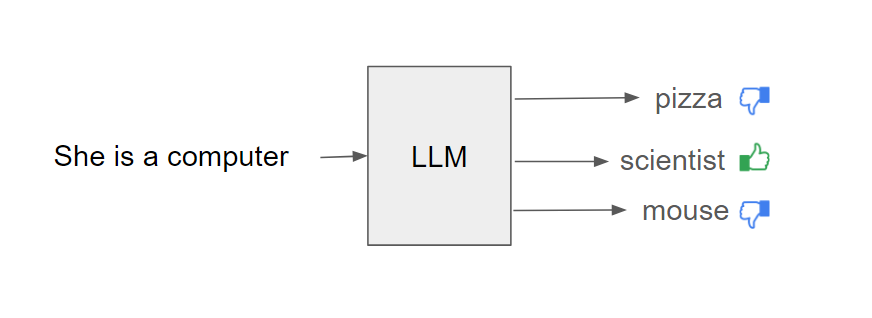

## Decoding
The simple output of the LLM is the next token probabilities. The decoding process refers to the process of generating multiple tokens from the LLM to produce the entire output text. It is a sequential process where tokens are generated one at a time, based on previously generated tokens.

**Example:**

For decoding you generate a probability for each possible token. For example if we have a vocabulary of 6 tokens \[I, you, like, love, pizza, pasta\]. Let's say you start by feeding in the LLM a single token, "you". The LLM would generate a probability vector of length 6 e.g. \[.1, .1, .3, .2, .1, .2\]. Then the LLM will choose the index with the highest probability (index 2), and then generate the corresponding token ("like"). Then based on the previous tokens the LLM will generate another probability vector e.g. \[0, 0, .1, .2, .4, .3\]. Then generate the next token ("pizza") and so on.

This is almost like a sequence of classification tasks, where each class is a possible token which can be generated.

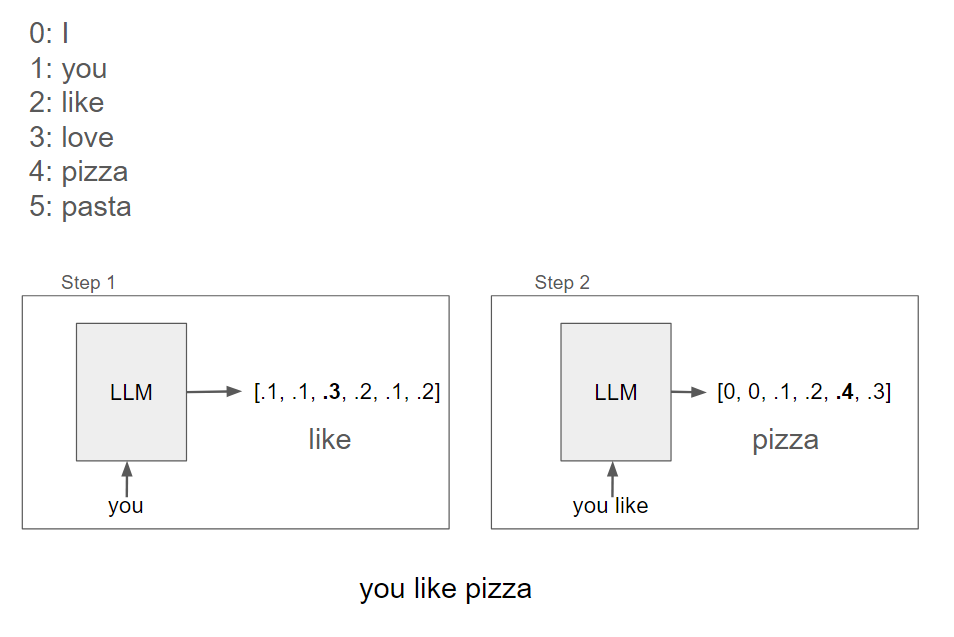

**Temperature** is an important hyperparameter for the generation process. In the previous example above we are using a temperature of 0, which is also called "Greedy" decoding which means that the LLM will always choose the highest probability token. If you choose a higher temperature value, the model will instead sample from the probabilities, the higher the temperature value, the more random the sampling.

# CLASSWORK STARTS HERE

### Question 3
Let's assume we are using a temperature value of 0, i.e. we are using greedy decoding. We are using the same vocabulary as before (\[I, you, like, love, pizza, pasta\]). First, we pass "I" into the model, then the model generates the following vector \[.05, 0, .4, .5, 0, .05\] then after generating the first token outputs the following vector \[0, .05, .05, .1, .6, .2\].

What three tokens is the final generated text?

### Answer 3

\<*Type your answer here*\>


## Transformers
The Transformer architecture is an artificial neural network architecture which is specifically designed to deal with text data. It is currently the most popular architecture to build LLMs. It is composed of multiple "self-attention" blocks, which aggregate information between different tokens (words) in the input.


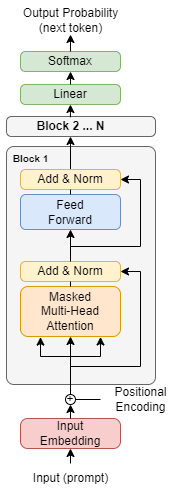

## Attention

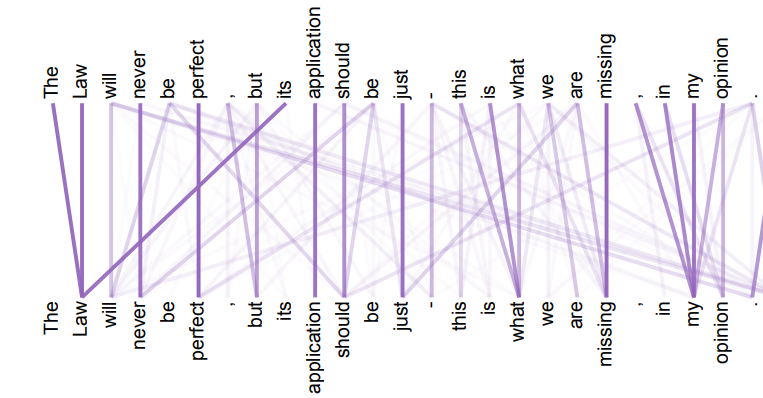

The transformer architecture uses a function called "self-attention". The basic idea of attention is similar to human attention, where you might choose to focus on certain things. Similary, in attention, each token determines how much to focus on each other token. In the image above, we can see each tokens "attention" to other tokens. The darker lines means that there is more attention between the two tokens. For example, in the image abovem the word "Law" attends most strongly to "The", "its" and "Law" (itself).

For an interactive visualization of attention you can checkout this notebook:
https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb#scrollTo=OJKU36QAfqOC

### Question 4

In the image above, which tokens does "my" attend the most strongly to? What is your intuition on why "my" might attend to those tokens the most?

### Answer 4

\<*Type your answer here*\>


## Pretraining vs. Finetuning


**Pretraining** refers to the process of training an LLM on a lot of text to give it a general understanding of language. The creator of the LLM will collect a lot of text data, and train the model using the language modelling objective.


After pretraining, we can use various methods methods to improve the performance for certain tasks...

**In-Context Learning**, which is sometimes called few-shot prompting, refers to providing a few examples to the LLM **in the prompt** which the LLM can use as demonstrations. For example, using the previous example, if we wanted to add three in-context examples:

"Answer the question.

Q: What is the population of the United Kingdom?
A: 68 million

Q: What is the capital of Japan?
A: Tokyo

Q: What is the largest continent by land area?
A: Asia

Q: What is the capital of the United States?
A:"

**Finetuning** involves updating the parameters of the model similar to what we have learned in previous modules like the ANN module. To finetune the model, we build training text examples like "Q: What is the population of the United Kingdom? A: 68 million" and then update the model parameters based on the language modelling object.

**Instruction-tuning** is a method of finetuning which specifically teaches LLMs to follow human instructions. This improves models' abilities to follow commands. Generally instruction tuning improves LLM performance in dialogue applications.

## How do you pick the right LLM?
Most LLMs are made by large companies with a large amount of financial and computational resources. It is very rare that an engineer will need to build an LLM for their usecase. Most of the time, the main thing is choosing the correct LLM for your task. There are a few considerations when considering which LLM to use.

1. API
2. Data
3. Licensing
4. Cost
5. Model Size

**API** - You will have to interact with different LLMs in different ways. For example, the only way to access the GPT models from OpenAI is to use their website or their web/programmatic APIs. They do not allow you to have full access to the model weights. On the other hand, a lot of Open Source models will not have nice web APIs to access the model with, often you will have to host the model yourself, and write code to run the model.

**Data** - Different models will be trained with different datasets. For example, Codex is trained with a lot of programming language data, so it is better solving programming problems.

**Licensing** - Certain LLMs do not allow for commercial use. For example, Meta, requires you to request a special license for commercial use if you have more than 700M active users.

**Cost** - Different web APIs for different LLMs have different costs, and if you are running a model by yourself, you need to account for server costs.

**Model Size** - Larger models, have the potential to be stronger more descriptive learners. They have the disadvantage of needing more data, and having higher computational costs such as needing more memory to run.


Another important factor when picking your LLM is to simply try different examples from your use case. You should make a few example use cases, and test out a few models with your example use cases. The metrics which are reported in a paper, may not accurately reflect your particular use case, so the best thing you can do is just test them yourself.




### Question 5

Pretend that you are a scientist who wants to keep up to date with current research. You would like to build an LLM to classify papers in your research area and figure out which are the most relevant to your research. Look up a few LLMs online and pick an LLM which you would want to try for this use case. Justify why you would start with trying out that LLM.

### Answer 5

\<*Type your answer here*\>

**Example Responses:**

Various LLMs will give you different responses to a single prompt, so it is a good idea to try out different LLMs to see which works best for your use case.

In [ ]:
llama2_chat_response("What is an angler fish?", model=13) # Llama2 Chat 13B

In [ ]:
llama2_chat_response("What is an angler fish?", model=70) # Llama2 Chat 70B

In [ ]:
llama3_simple_response("What is an angler fish?", model=8) # Llama3 Chat 8B

In [ ]:
llama3_simple_response("What is an angler fish?", model=70) # Llama3 Chat 70B

In [ ]:
claude_simple_response("What is an angler fish?") # Claude 3 Sonnet

### When you are ready to submit, upload this Notebook to your Github repository. (Check the guide to Github Classrooms to see how this works.)

### Please don't forget to submit the Daily Survey ([link](https://cmu.ca1.qualtrics.com/jfe/form/SV_dj2b7qewe53kwTA)) at least 1 hr before class starts.

## Bonus: Multimodal Models

So far we have only covered language models. Multimodal models combine different modalities or forms of information. One very common combination is images and text. CLIP is trained to predict an image caption based on the image as input and then can be used on a variety of tasks, such as image classification.

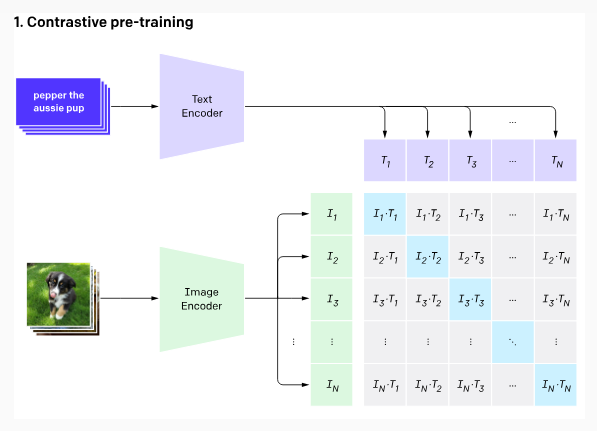

You can read more about CLIP here: https://openai.com/index/clip/

### References
Attention is all you need: https://arxiv.org/pdf/1706.03762

The Annotated Transformer: https://nlp.seas.harvard.edu/annotated-transformer/

Improving Language Understanding by Generative Pre-Training: https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf

Codex: https://openai.com/blog/openai-codex

LLaMA License: https://ai.meta.com/llama/license/

LLaMA: https://huggingface.co/meta-llama

Gemini: https://gemini.google.com/

DAIR AI prompt guide: https://www.promptingguide.ai/

https://www.ibm.com/topics/instruction-tuning

CLIP: https://openai.com/index/clip/

Claude: https://www.anthropic.com/news/claude-3-family

Images:

https://ai.stackexchange.com/questions/40179/how-does-the-decoder-only-transformer-architecture-work

lalawidi flaticon.com